<a href="https://www.kaggle.com/code/ryansaul85/customer-segmentation-using-clustering?scriptVersionId=101192433" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer Segmentation Using Clustering

## Ryan Saul

### Questions to answer

- Your end user and the value that your project provides to them

- Quantifiable results based on the research that you've conducted

- The visuals that you chose and what they represent for your research

- Next steps that you'd take to expand on your work

- A specified research question that your model addresses

- How you chose your model specification and what alternatives you compared it to

- The practical uses of your model for an audience of interest

- Any weak points or shortcomings of your model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

!pip install umap-learn
import warnings
warnings.filterwarnings('ignore')

## Understanding the Data

### What each column means
- ID: basic identification number of each customer
- Sex:
 - Male (0) | Female (1)
- Marital Status:
 - Single (0) | Not single (1)
- Age: years
- Education:
 - Unknown (0) | High school (1) | In college (2) | Graduated College (3)
- Income: yearly ($)
- Occupation
 - Unemployed(0) | Basic employee (1) | High level employee (2)
- Settlement size
 - Small city (0) | Medium city (1) | Large city (2)

In [2]:
url = 'https://raw.githubusercontent.com/RyanSaul85/Clustering/main/segmentation%20data.csv'
data = pd.read_csv(url)    

data.head()

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0  100000001    0               0   67          2  124670           1   
1  100000002    1               1   22          1  150773           1   
2  100000003    0               0   49          1   89210           0   
3  100000004    0               0   45          1  171565           1   
4  100000005    0               0   53          1  149031           1   

   Settlement size  
0                2  
1                2  
2                0  
3                1  
4                1

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [4]:
data.isna().sum()

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [5]:
data.describe()

ID          Sex  Marital status          Age   Education  \
count  2.000000e+03  2000.000000     2000.000000  2000.000000  2000.00000   
mean   1.000010e+08     0.457000        0.496500    35.909000     1.03800   
std    5.774946e+02     0.498272        0.500113    11.719402     0.59978   
min    1.000000e+08     0.000000        0.000000    18.000000     0.00000   
25%    1.000005e+08     0.000000        0.000000    27.000000     1.00000   
50%    1.000010e+08     0.000000        0.000000    33.000000     1.00000   
75%    1.000015e+08     1.000000        1.000000    42.000000     1.00000   
max    1.000020e+08     1.000000        1.000000    76.000000     3.00000   

              Income   Occupation  Settlement size  
count    2000.000000  2000.000000      2000.000000  
mean   120954.419000     0.810500         0.739000  
std     38108.824679     0.638587         0.812533  
min     35832.000000     0.000000         0.000000  
25%     97663.250000     0.000000         0.000000  
50%    115548.500000     1.000000         1.000000  
75%    138072.250000     1.000000         1.000000  
max    309364.000000     2.000000         2.000000

In [6]:
print(data['Sex'].value_counts())
print(data['Marital status'].value_counts())
print(data['Education'].value_counts())
print(data['Occupation'].value_counts())
print(data['Settlement size'].value_counts())

0    1086
1     914
Name: Sex, dtype: int64
0    1007
1     993
Name: Marital status, dtype: int64
1    1386
2     291
0     287
3      36
Name: Education, dtype: int64
1    1113
0     633
2     254
Name: Occupation, dtype: int64
0    989
1    544
2    467
Name: Settlement size, dtype: int64


## Visualizations

### Continuous Variables
- Age
- Income

### Categorical/Discrete Variables
- Sex
- Marital Status
- Education
- Occupation
- Settlement Size

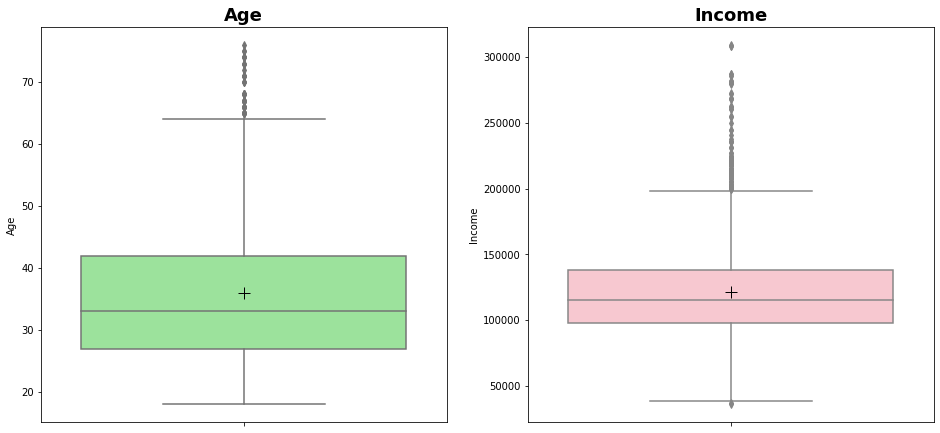

In [7]:
plt.figure(figsize=(16,16))

plt.subplot2grid((2,2), (0,0))
box1 = sns.boxplot(y=data['Age'], color='lightgreen', showmeans=True, 
                   meanprops={"marker": "+", "markeredgecolor": "black", "markersize": "12"})
plt.title('Age', fontsize=18, fontweight='bold')

plt.subplot2grid((2,2), (0,1))
box2 = sns.boxplot(y=data['Income'], color='pink',showmeans=True, 
                   meanprops={"marker": "+",  "markeredgecolor": "black",  "markersize": "12"})
plt.title('Income', fontsize=18, fontweight='bold')
plt.show()

In [8]:
print('Age Statistics')
print(round(data['Age'].describe(),2))
print('---------------------')
print('Income Statistics')
print(round(data['Income'].describe(),2))

Age Statistics
count    2000.00
mean       35.91
std        11.72
min        18.00
25%        27.00
50%        33.00
75%        42.00
max        76.00
Name: Age, dtype: float64
---------------------
Income Statistics
count      2000.00
mean     120954.42
std       38108.82
min       35832.00
25%       97663.25
50%      115548.50
75%      138072.25
max      309364.00
Name: Income, dtype: float64


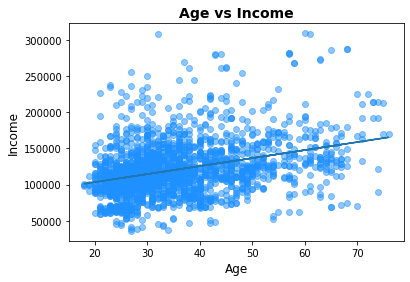

In [9]:
plt.scatter(x = data['Age'], y = data['Income'], alpha=0.5, color='dodgerblue')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.title('Age vs Income', fontsize=14, fontweight='bold')

#calculate equation for trendline
z = np.polyfit(data['Age'], data['Income'], 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(data['Age'], p(data['Age']));

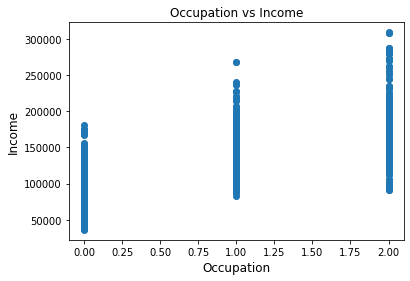

In [10]:
plt.scatter(x = data['Occupation'], y = data['Income'])
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.title('Occupation vs Income');

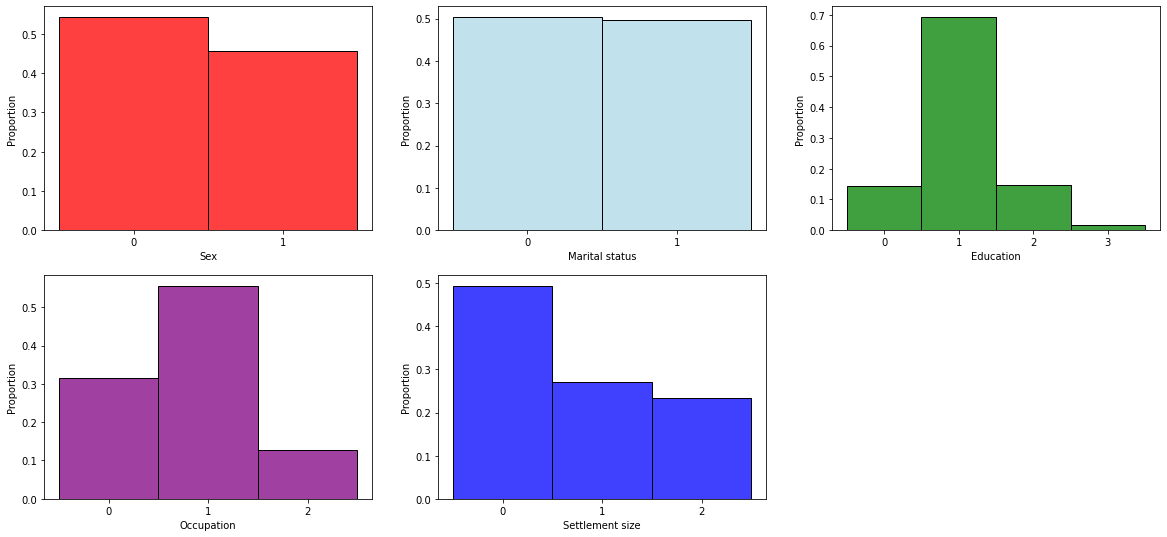

In [11]:
plt.figure(figsize=(20,14))

plt.subplot2grid((3,3), (0,0))
sns.histplot(data['Sex'].astype(str), stat='proportion', color='r')
plt.subplot2grid((3,3), (0,1))
sns.histplot(data['Marital status'].astype(str), stat='proportion', color='lightblue')
plt.subplot2grid((3,3), (0,2))
sns.histplot(data['Education'].astype(str).sort_values(), stat='proportion', color='g')
plt.subplot2grid((3,3), (1,0))
sns.histplot(data['Occupation'].astype(str).sort_values(), stat='proportion', color='purple')
plt.subplot2grid((3,3), (1,1))
sns.histplot(data['Settlement size'].astype(str).sort_values(), stat='proportion', color='blue')
plt.show()

### Elbow Method

- This method is used to determine the most efficient number of clusters (K)
- WCSS: Within Cluster Sum of Squares
 - the sum of squared distance between each point and the centroid in a cluster
- Helps to avoid overfitting

In [12]:
wcss = {'wcss_score':[], 'no_of_clusters':[]}
for i in range(1,11):
    kmeans = KMeans(i, random_state=111)
    kmeans.fit(data)
    wcss['wcss_score'].append(kmeans.inertia_)
    wcss['no_of_clusters'].append(i)
wcss_df = pd.DataFrame(wcss)
wcss_df.head(8)

wcss_score  no_of_clusters
0  2.903780e+12               1
1  1.215193e+12               2
2  6.736592e+11               3
3  3.777277e+11               4
4  2.495899e+11               5
5  1.772316e+11               6
6  1.301065e+11               7
7  9.687875e+10               8

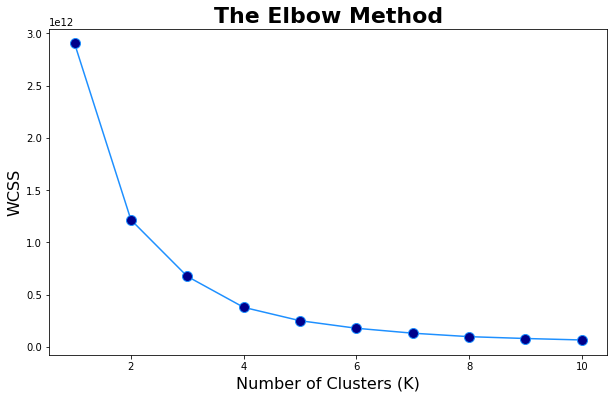

In [13]:
plt.figure(figsize=(10,6))
plt.plot(wcss_df['no_of_clusters'], wcss_df['wcss_score'], color='dodgerblue', marker='o', markerfacecolor='darkblue', markersize=10)
plt.title('The Elbow Method', fontsize=22, fontweight='bold', color='black')
plt.xlabel('Number of Clusters (K)', fontsize=16)
plt.ylabel('WCSS', fontsize=16)
plt.show()

## KMeans and MiniBatch KMeans

### KMeans
- Group similar data points together and discover underlying patterns
- The user provides the number of clusters (K)
- Clusters are isotropic or radially symmetrical
 
### MiniBatch KMeans
 - Only uses part of the data on large datasets to reduce costs
 - Typical results are not as precise as KMeans

In [14]:
X = data.iloc[:,1:8]

# Scaling and using PCA 

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2).fit_transform(X_std)

891 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


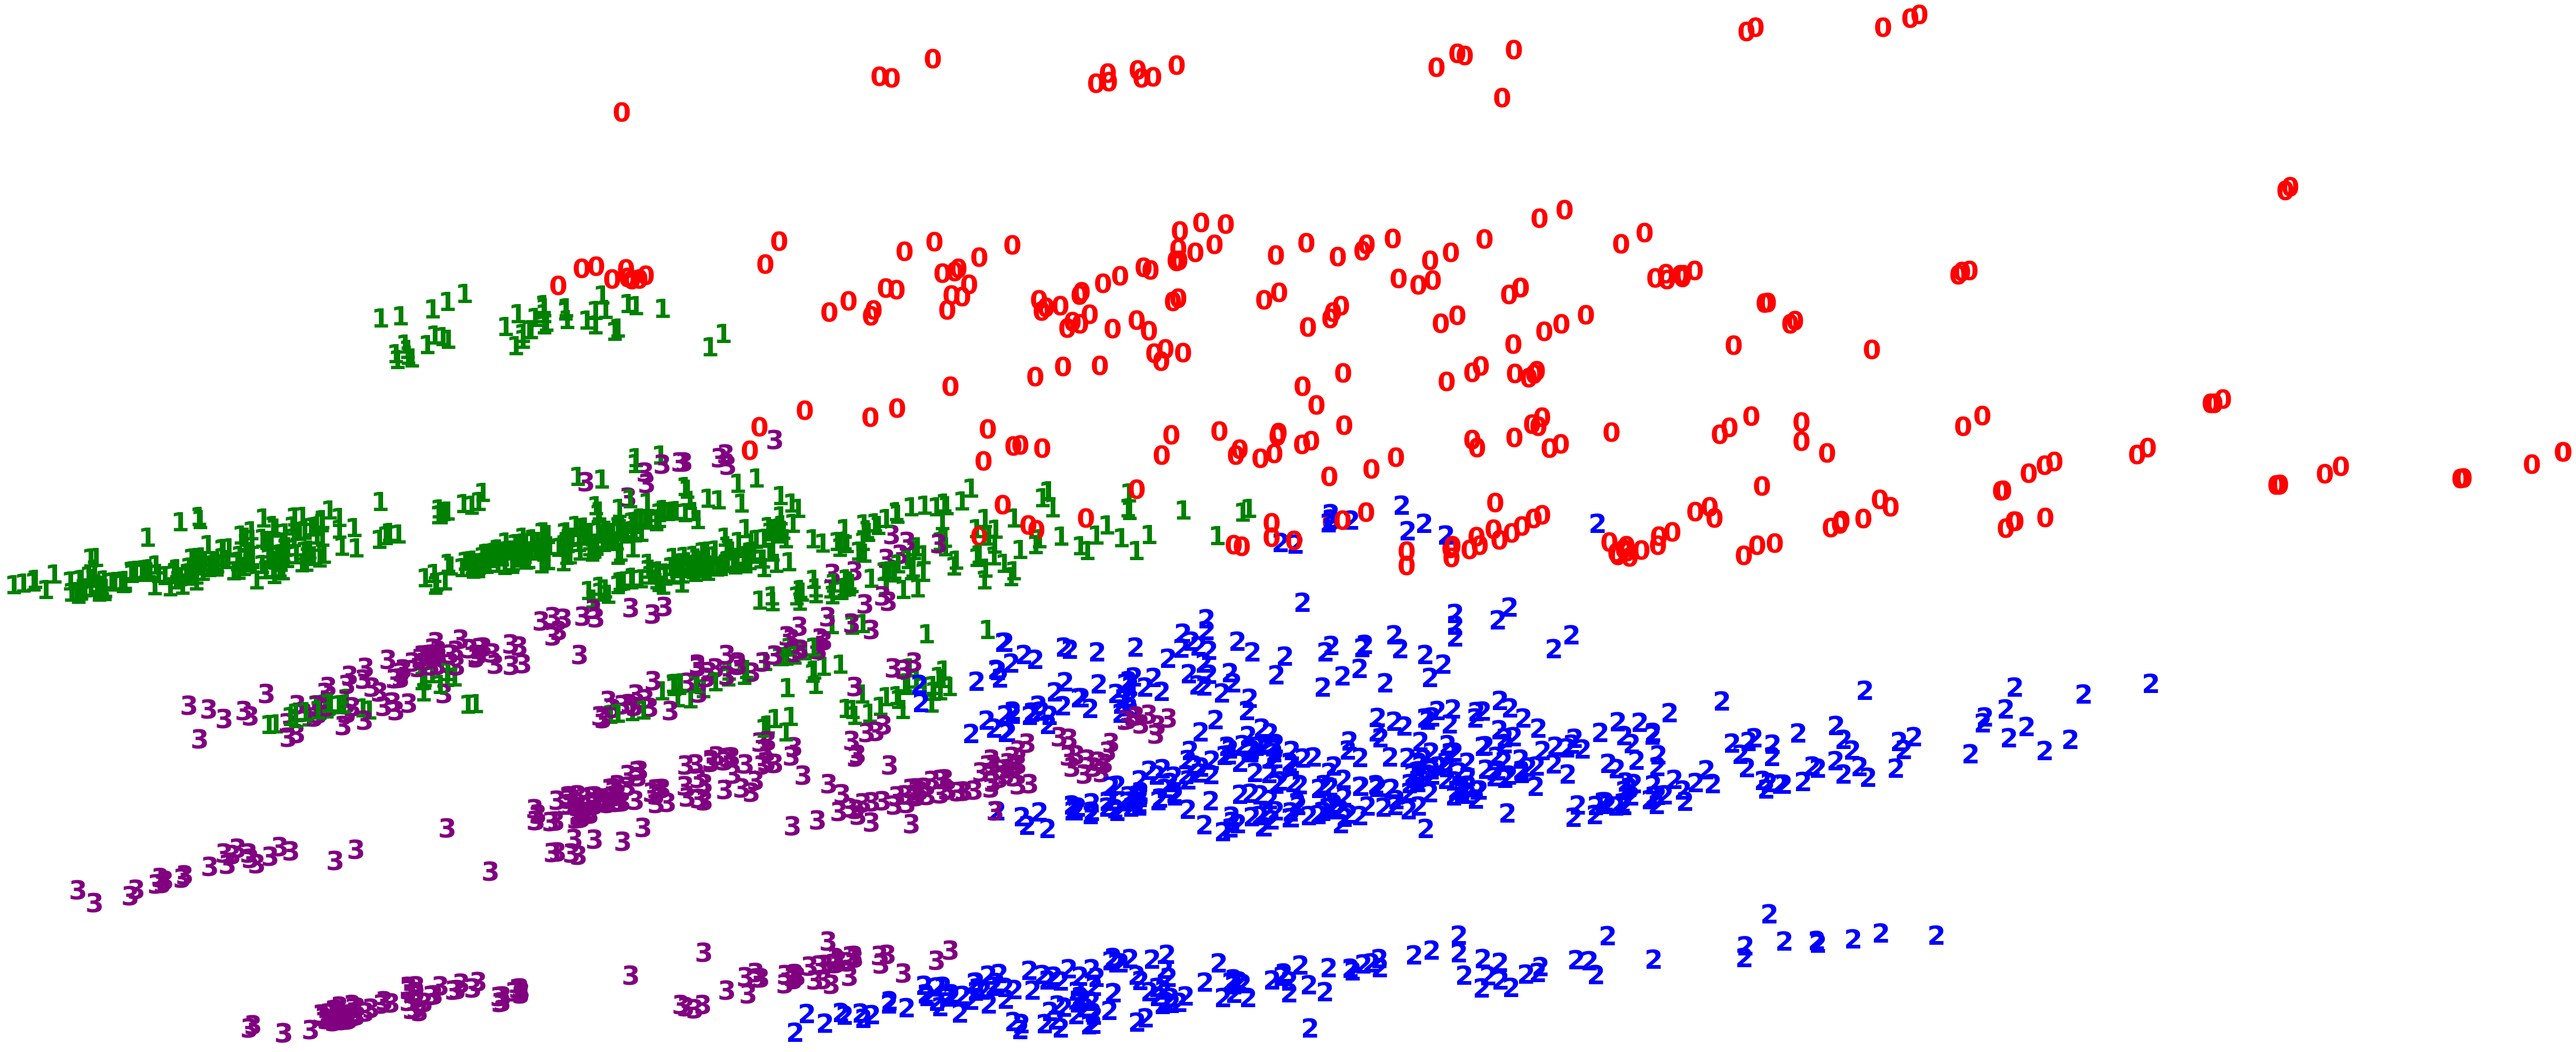

In [15]:
kmeans_cluster = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=111)
y_pred = kmeans_cluster.fit_predict(X_std)
%timeit kmeans_cluster.fit(X_std)

plt.figure(figsize=(10,5))
colors = ('r', 'g', 'b', 'purple')
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]), color=colors[y_pred[i]], fontdict={'weight': 'bold', 'size': 50})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

8.35 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


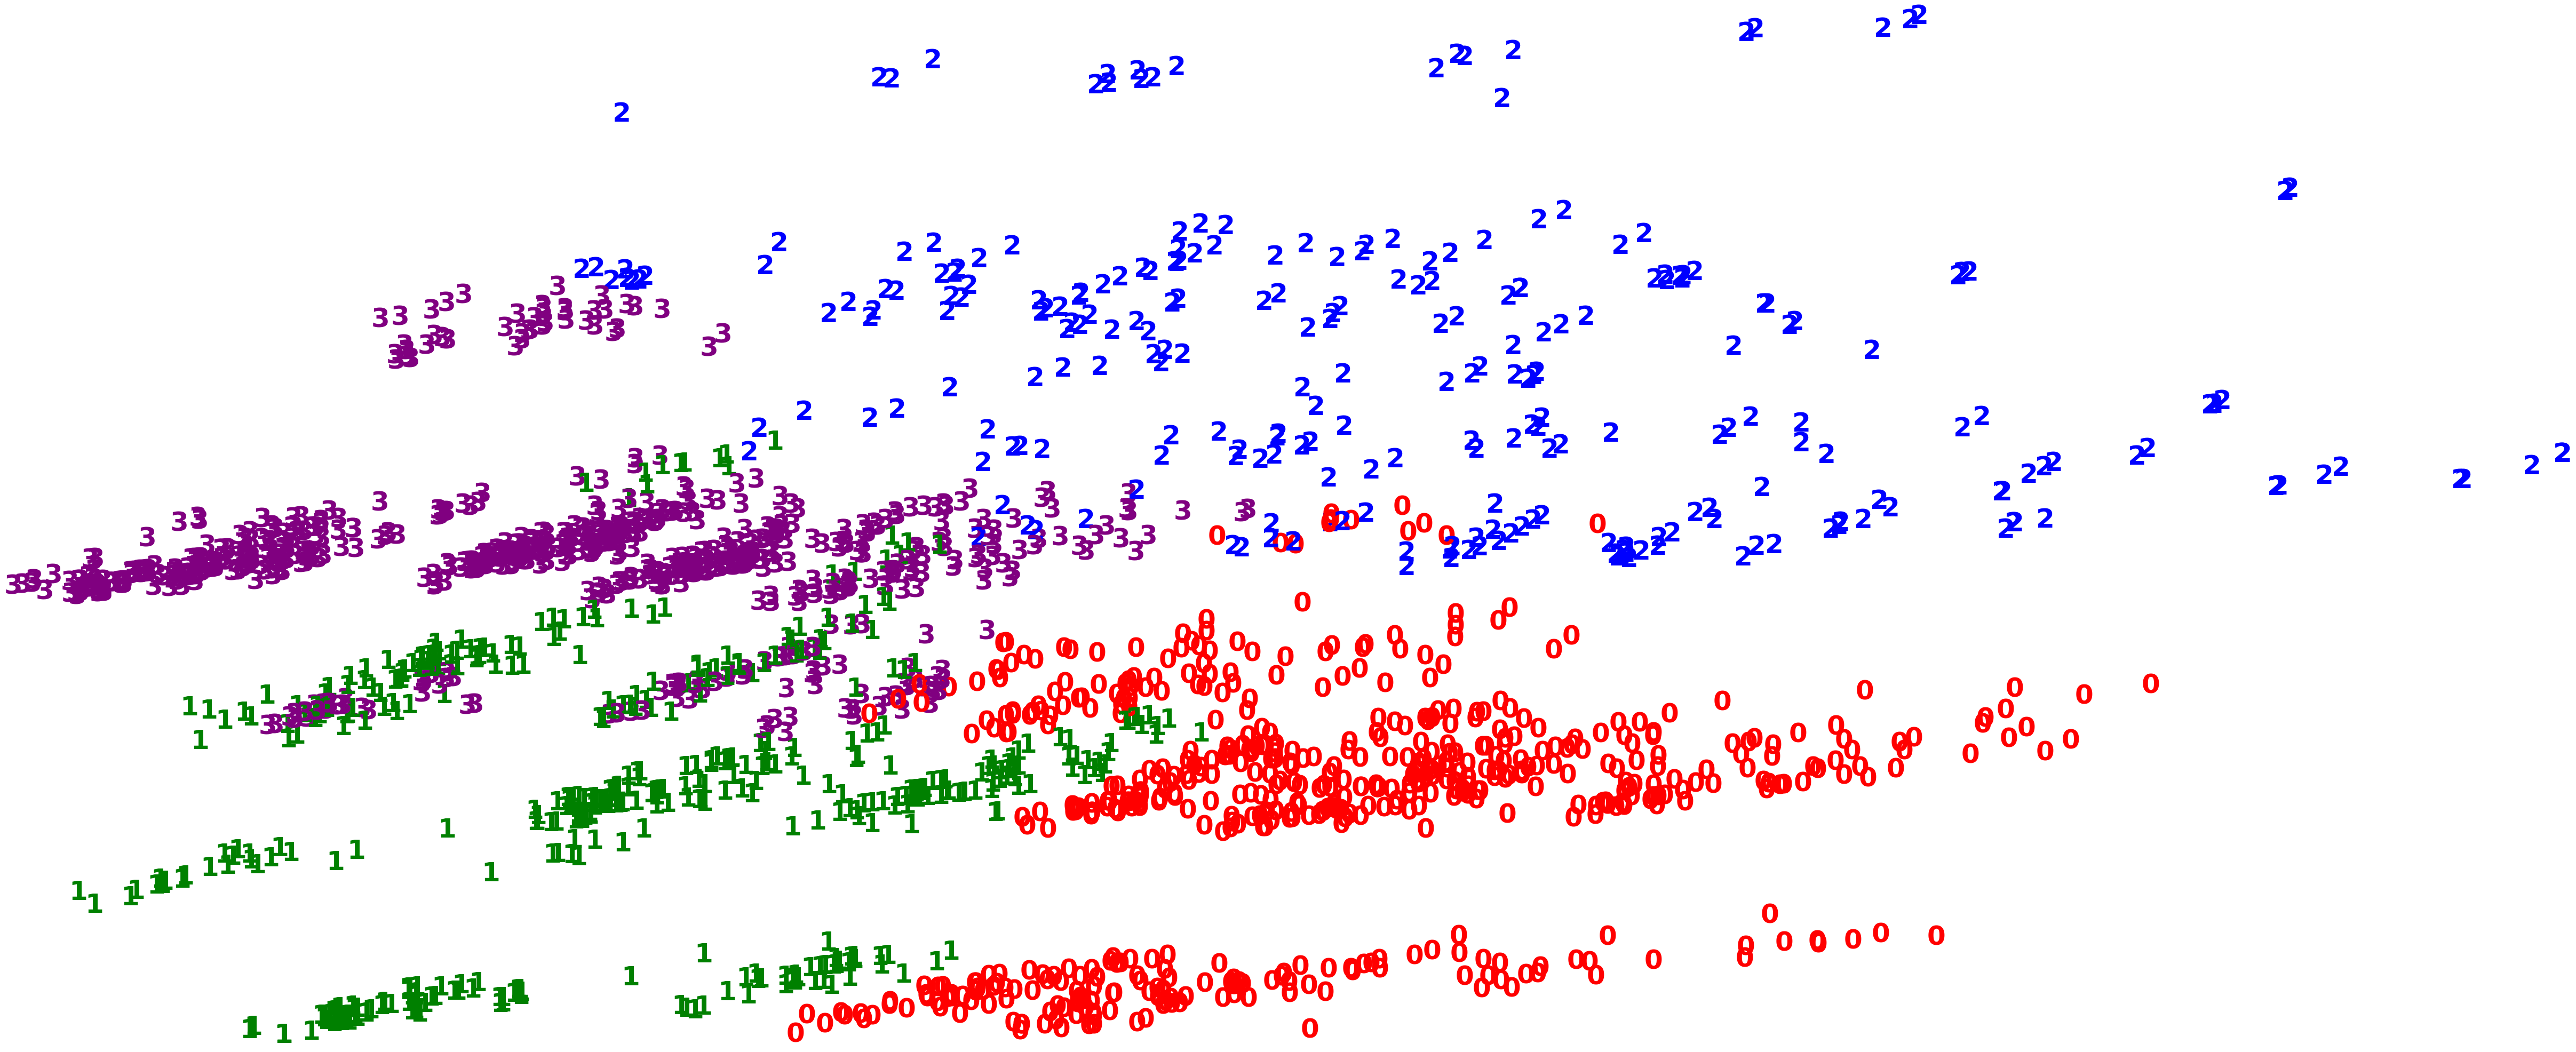

In [16]:
minikmeans_cluster = MiniBatchKMeans(init='random', n_clusters=4,  max_iter=300, n_init=10, batch_size=50)
y_pred_mini = minikmeans_cluster.fit_predict(X_std)
%timeit minikmeans_cluster.fit(X_std)

plt.figure(figsize=(10,5))
colors = ('r', 'g', 'b', 'purple')
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred_mini[i]), color=colors[y_pred_mini[i]], fontdict={'weight': 'bold', 'size': 50})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [17]:
labels_2 = KMeans(n_clusters=2, random_state=111).fit_predict(X_std)
labels_3 = KMeans(n_clusters=3, random_state=111).fit_predict(X_std)
labels_4 = KMeans(n_clusters=4, random_state=111).fit_predict(X_std)

pred_2 = KMeans(n_clusters=2, random_state=111).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=111).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=111).fit_predict(X_std)

print("2 Cluster KMeans Silhouette Score: {}".format(metrics.silhouette_score(X_std, labels_2, metric='euclidean')))
print("3 Cluster KMeans Silhouette Score: {}".format(metrics.silhouette_score(X_std, labels_3, metric='euclidean')))
print("4 Cluster KMeans Silhouette Score: {}".format(metrics.silhouette_score(X_std, labels_4, metric='euclidean')))
print('------------------------------------------------------')
print("2 Cluster KMeans ARI Score: {}".format(metrics.adjusted_rand_score(y_pred, pred_2)))
print("3 Cluster KMeans ARI Score: {}".format(metrics.adjusted_rand_score(y_pred, pred_3)))
print("4 Cluster KMeans ARI Score: {}".format(metrics.adjusted_rand_score(y_pred, pred_4)))

2 Cluster KMeans Silhouette Score: 0.24977843688092582
3 Cluster KMeans Silhouette Score: 0.2711846855734802
4 Cluster KMeans Silhouette Score: 0.26879180394522123
------------------------------------------------------
2 Cluster KMeans ARI Score: 0.4082900175836153
3 Cluster KMeans ARI Score: 0.5773015850647832
4 Cluster KMeans ARI Score: 1.0


In [18]:
labels_2_mini = MiniBatchKMeans(n_clusters=2, random_state=111).fit_predict(X_std)
labels_3_mini = MiniBatchKMeans(n_clusters=3, random_state=111).fit_predict(X_std)
labels_4_mini = MiniBatchKMeans(n_clusters=4, random_state=111).fit_predict(X_std)

pred_2_mini = MiniBatchKMeans(n_clusters=2, random_state=111).fit_predict(X_std)
pred_3_mini = MiniBatchKMeans(n_clusters=3, random_state=111).fit_predict(X_std)
pred_4_mini = MiniBatchKMeans(n_clusters=4, random_state=111).fit_predict(X_std)

print("2 Cluster MiniBatch KMeans Silhouette Score: {}".format(metrics.silhouette_score(X_std, labels_2_mini, metric='euclidean')))
print("3 Cluster MiniBatch KMeans Silhouette Score: {}".format(metrics.silhouette_score(X_std, labels_3_mini, metric='euclidean')))
print("4 Cluster MiniBatch KMeans Silhouette Score: {}".format(metrics.silhouette_score(X_std, labels_4_mini, metric='euclidean')))
print('----------------------------------------------------------------')
print("2 Cluster MiniBatch KMeans ARI Score: {}".format(metrics.adjusted_rand_score(y_pred_mini, pred_2_mini)))
print("3 Cluster MiniBatch KMeans ARI Score: {}".format(metrics.adjusted_rand_score(y_pred_mini, pred_3_mini)))
print("4 Cluster MiniBatch KMeans ARI Score: {}".format(metrics.adjusted_rand_score(y_pred_mini, pred_4_mini)))

2 Cluster MiniBatch KMeans Silhouette Score: 0.2509801015057284
3 Cluster MiniBatch KMeans Silhouette Score: 0.23574232726704547
4 Cluster MiniBatch KMeans Silhouette Score: 0.26241917369349177
----------------------------------------------------------------
2 Cluster MiniBatch KMeans ARI Score: 0.40128610512264007
3 Cluster MiniBatch KMeans ARI Score: 0.5017977831880983
4 Cluster MiniBatch KMeans ARI Score: 0.7906316154175169


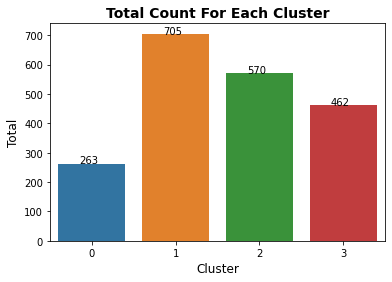

In [19]:
ax = sns.countplot(y_pred)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Total', fontsize=12)
plt.title('Total Count For Each Cluster', fontsize=14, fontweight='bold')
plt.show();

In [20]:
print('Cluster 0')
print(X[y_pred==0].head(2))
print('-------------------------------------------------------------------------------')
print('Cluster 1')
print(X[y_pred==1].head(2))
print('-------------------------------------------------------------------------------')
print('Cluster 2')
print(X[y_pred==2].head(2))
print('-------------------------------------------------------------------------------')
print('Cluster 3')
print(X[y_pred==3].head(2))

Cluster 0
   Sex  Marital status  Age  Education  Income  Occupation  Settlement size
0    0               0   67          2  124670           1                2
8    0               1   61          2  151591           0                0
-------------------------------------------------------------------------------
Cluster 1
    Sex  Marital status  Age  Education  Income  Occupation  Settlement size
1     1               1   22          1  150773           1                2
10    1               1   25          1  108469           1                0
-------------------------------------------------------------------------------
Cluster 2
   Sex  Marital status  Age  Education  Income  Occupation  Settlement size
3    0               0   45          1  171565           1                1
4    0               0   53          1  149031           1                1
-------------------------------------------------------------------------------
Cluster 3
   Sex  Marital status  Age  Educ

### Hierarchical Clustering

#### Bottom-up approach also called Agglomerative Clustering
- Starts with individual observations as stand alone clusters
- Then combines the two most similar 

#### Linkage Types
- Complete
 - Links using furthest observations
 - Resulting groups are highly compact
- Average
 - Links based on centroids
 - Ignores boundary points
- Ward
 - Spherical clusters that are cohesive inside
 - Tends to find clusters of similar size

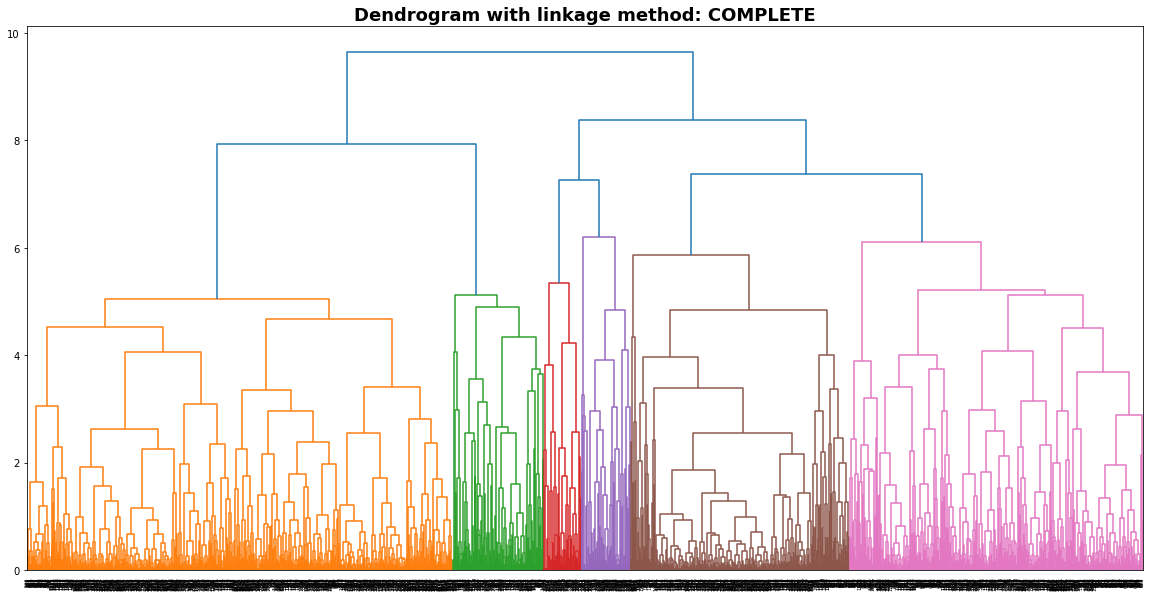

In [21]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: COMPLETE", fontsize=18, fontweight='bold')
dendrogram(linkage(X_std, method='complete'))
plt.show()

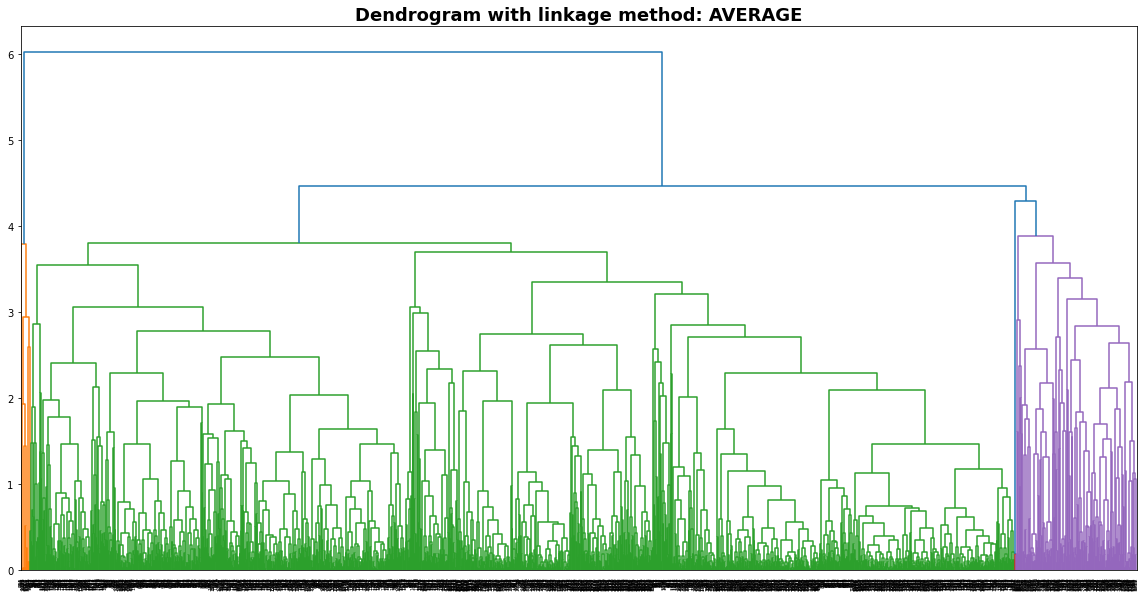

In [22]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: AVERAGE", fontsize=18, fontweight='bold')
dendrogram(linkage(X_std, method='average'))
plt.show()

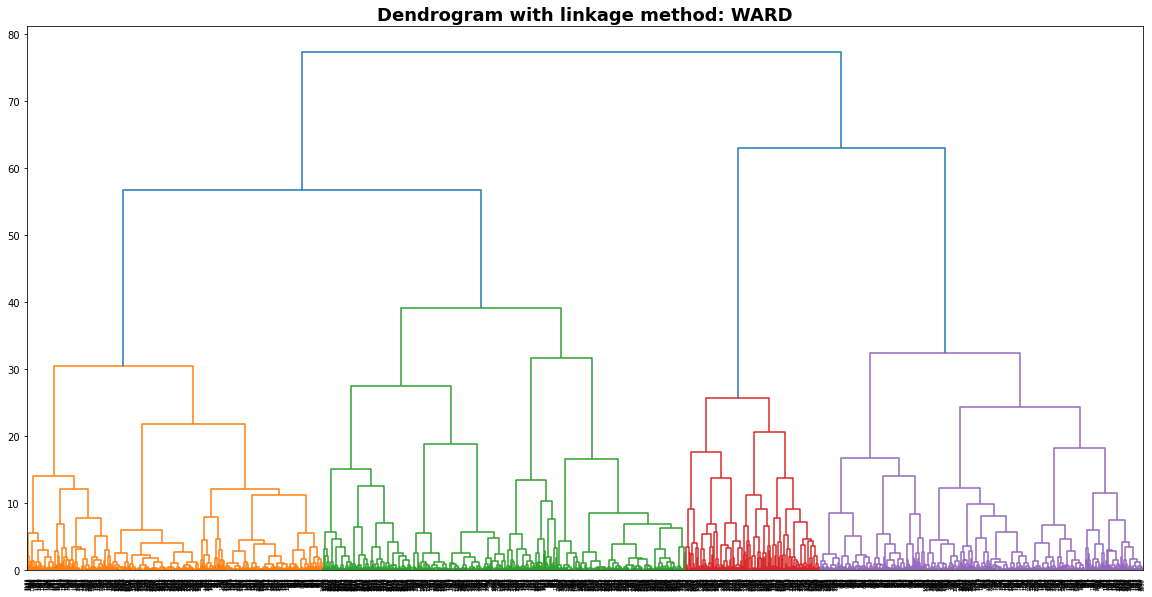

In [23]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: WARD", fontsize=18, fontweight='bold')
dendrogram(linkage(X_std, method='ward'))
plt.show()

#### ARI and Silhouette Score for each linkage method

In [24]:
linkage_methods = ["ward", "average", "complete"]

In [25]:
agg_cluster_average = AgglomerativeClustering(linkage="average", 
                                      affinity='cosine',
                                      n_clusters=2)

clusters_average = agg_cluster_average.fit_predict(X_std)

print("ARI score of linkage method average: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_average)))

print("Silhouette score of linkage method average: {}".format(
    metrics.silhouette_score(X_std, clusters_average, metric='euclidean')))

ARI score of linkage method average: 0.42600801490860796
Silhouette score of linkage method average: 0.22023602771959108


In [26]:
agg_cluster_complete = AgglomerativeClustering(linkage="complete", 
                                      affinity='cosine',
                                      n_clusters=2)

clusters_complete = agg_cluster_complete.fit_predict(X_std)

print("ARI score of linkage method complete: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_complete)))

print("Silhouette score of linkage method complete: {}".format(
    metrics.silhouette_score(X_std, clusters_complete, metric='euclidean')))

ARI score of linkage method complete: 0.2678814306198017
Silhouette score of linkage method complete: 0.23245075377226884


In [27]:
agg_cluster_ward = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=2)

clusters_ward = agg_cluster_ward.fit_predict(X_std)

print("ARI score of linkage method ward: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_ward)))

print("Silhouette score of linkage method ward: {}".format(
    metrics.silhouette_score(X_std, clusters_ward, metric='euclidean')))

ARI score of linkage method ward: 0.33862772165518806
Silhouette score of linkage method ward: 0.23099458010188773


In [28]:
ari_ward = metrics.adjusted_rand_score(y_pred, clusters_ward)
sil_ward = metrics.silhouette_score(X_std, clusters_ward, metric='euclidean')
ari_complete = metrics.adjusted_rand_score(y_pred, clusters_complete)
sil_complete = metrics.silhouette_score(X_std, clusters_complete, metric='euclidean')
ari_average = metrics.adjusted_rand_score(y_pred, clusters_average)
sil_average = metrics.silhouette_score(X_std, clusters_average, metric='euclidean')

In [29]:
print('Silhouette WARD:     ', round(sil_ward, 4))
print('Silhouette COMPLETE: ', round(sil_complete, 4))
print('Silhouette AVERAGE:  ', round(sil_average, 4))
print('------------------------------')
print('ARI WARD:     ', round(ari_ward, 4))
print('ARI COMPLETE: ', round(ari_complete, 4))
print('ARI AVERAGE:  ', round(ari_average, 4))

Silhouette WARD:      0.231
Silhouette COMPLETE:  0.2325
Silhouette AVERAGE:   0.2202
------------------------------
ARI WARD:      0.3386
ARI COMPLETE:  0.2679
ARI AVERAGE:   0.426


#### DBSCAN

In [30]:
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when min_samples=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(1,51)

for i in range(2,11):
    dbscan_cluster = DBSCAN(eps=2, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when min_samples=1 is: 114
Number of clusters when min_samples=2 is: 7
Number of clusters when min_samples=3 is: 6
Number of clusters when min_samples=4 is: 6
Number of clusters when min_samples=5 is: 6
Number of clusters when min_samples=6 is: 5
Number of clusters when min_samples=7 is: 5
Number of clusters when min_samples=8 is: 5
Number of clusters when min_samples=9 is: 5
Number of clusters when min_samples=10 is: 5


In [31]:
for i in [0.01,0.1,0.5,1,1.5,2,2.5,3,3.5,4,5]:
    dbscan_cluster = DBSCAN(eps=i, min_samples=1, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when eps={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when eps=0.01 is: 1919
Number of clusters when eps=0.1 is: 1141
Number of clusters when eps=0.5 is: 202
Number of clusters when eps=1 is: 114
Number of clusters when eps=1.5 is: 50
Number of clusters when eps=2 is: 8
Number of clusters when eps=2.5 is: 1
Number of clusters when eps=3 is: 1
Number of clusters when eps=3.5 is: 1
Number of clusters when eps=4 is: 1
Number of clusters when eps=5 is: 1


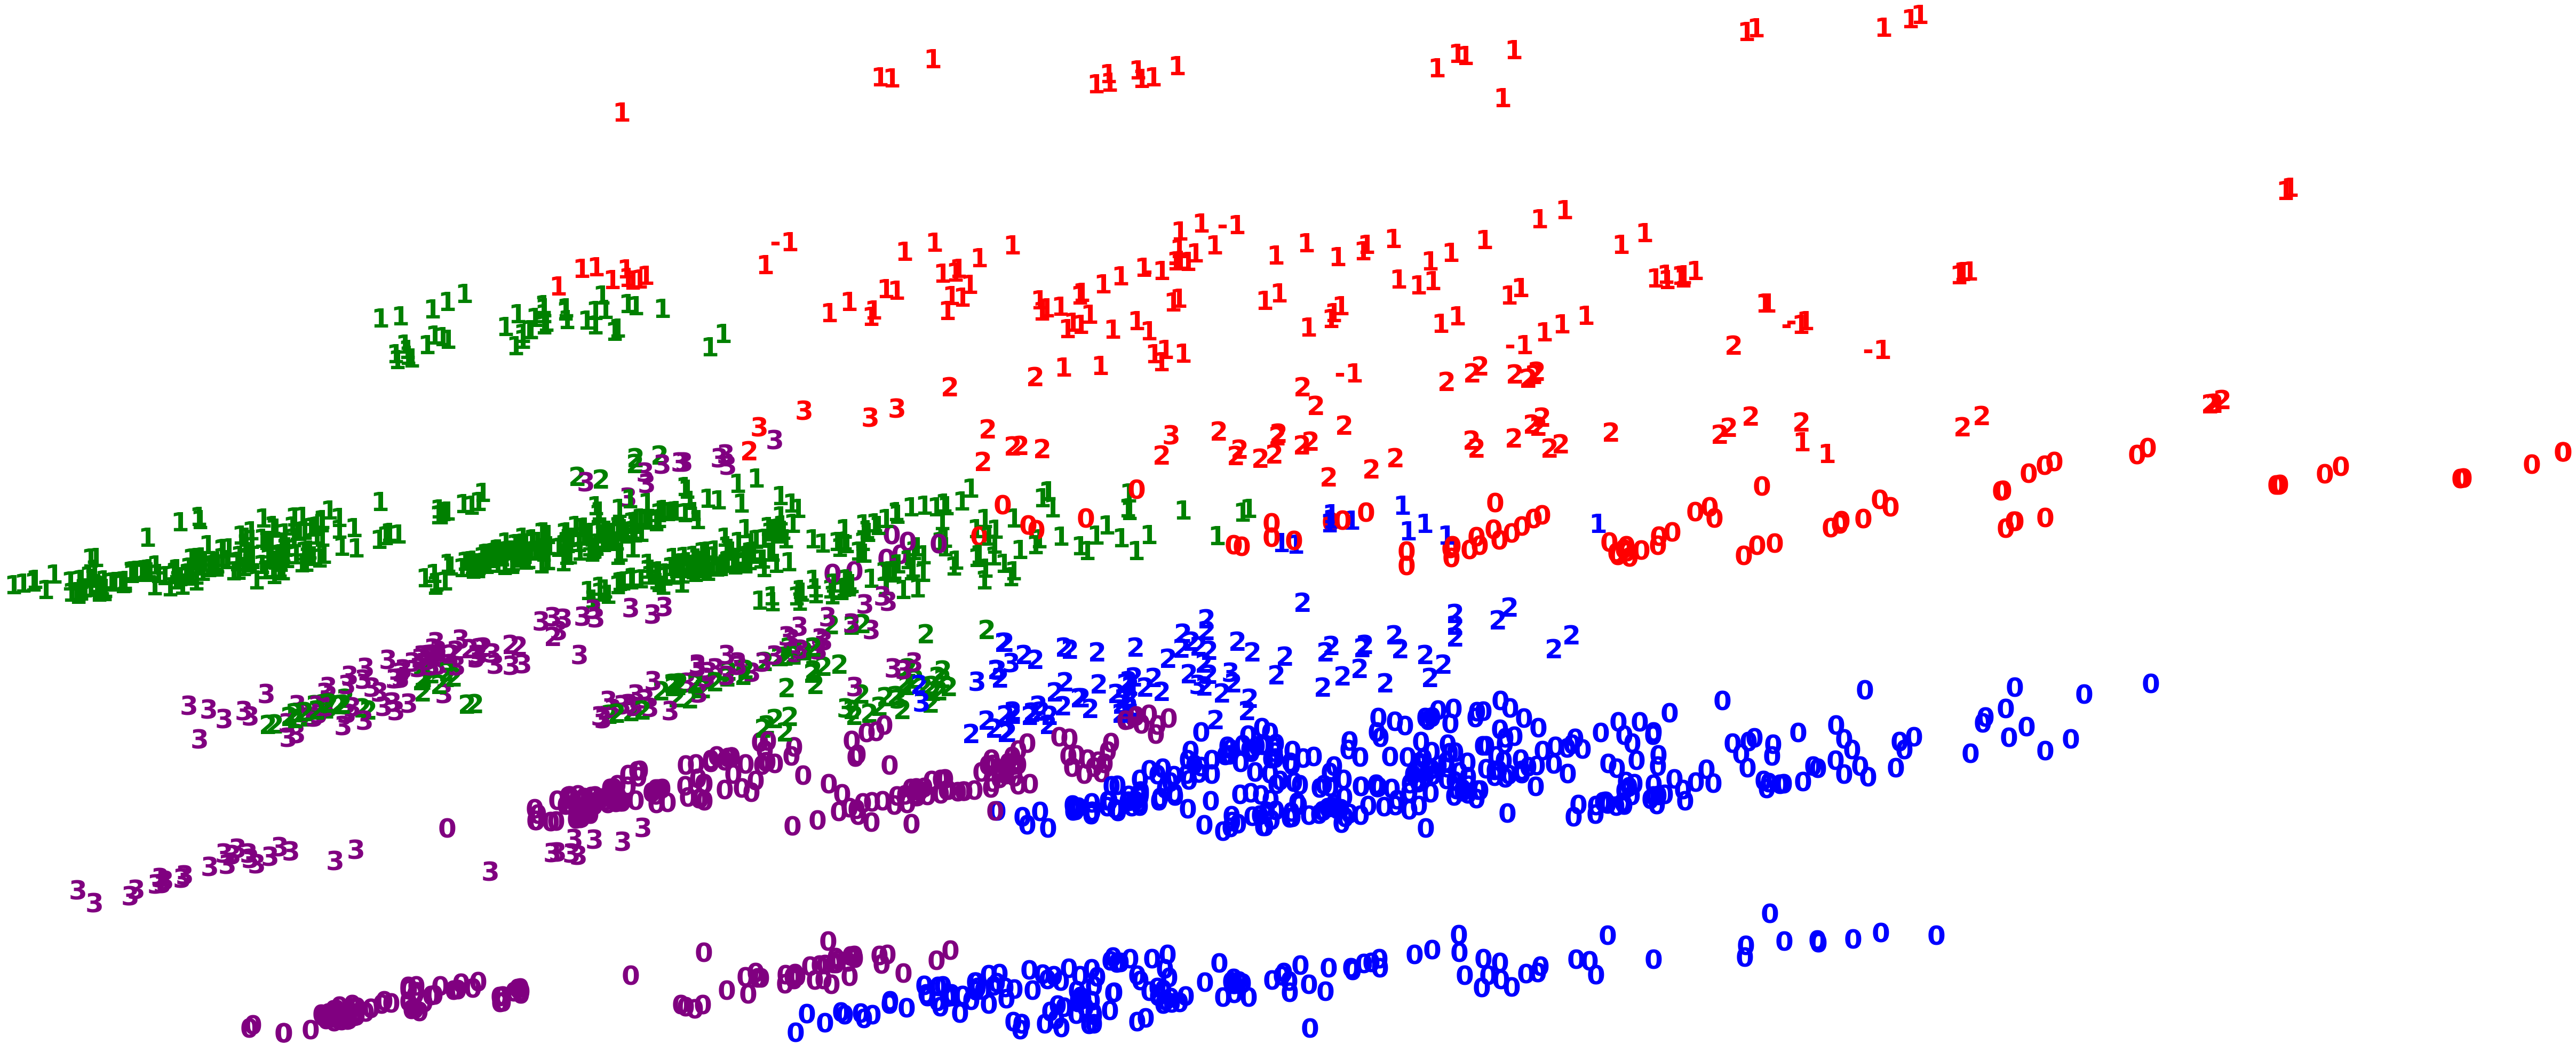

In [32]:
dbscan_cluster = DBSCAN(eps=2, min_samples=6, metric="euclidean")
clusters = dbscan_cluster.fit_predict(X_std)
pca = PCA(n_components=2).fit_transform(X_std)
plt.figure(figsize=(10,5))
colors = ('r', 'g', 'b', 'purple')
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colors[y_pred[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [33]:
print("DBSCAN ARI:        {}"
      .format(metrics.adjusted_rand_score(y_pred, clusters)))

print("DBSCAN Silhouette: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

DBSCAN ARI:        0.4284367033865774
DBSCAN Silhouette: 0.17561709392173486


#### Gaussian

In [34]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=4, random_state=111)

# Fit model
clusters_gau = gmm_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

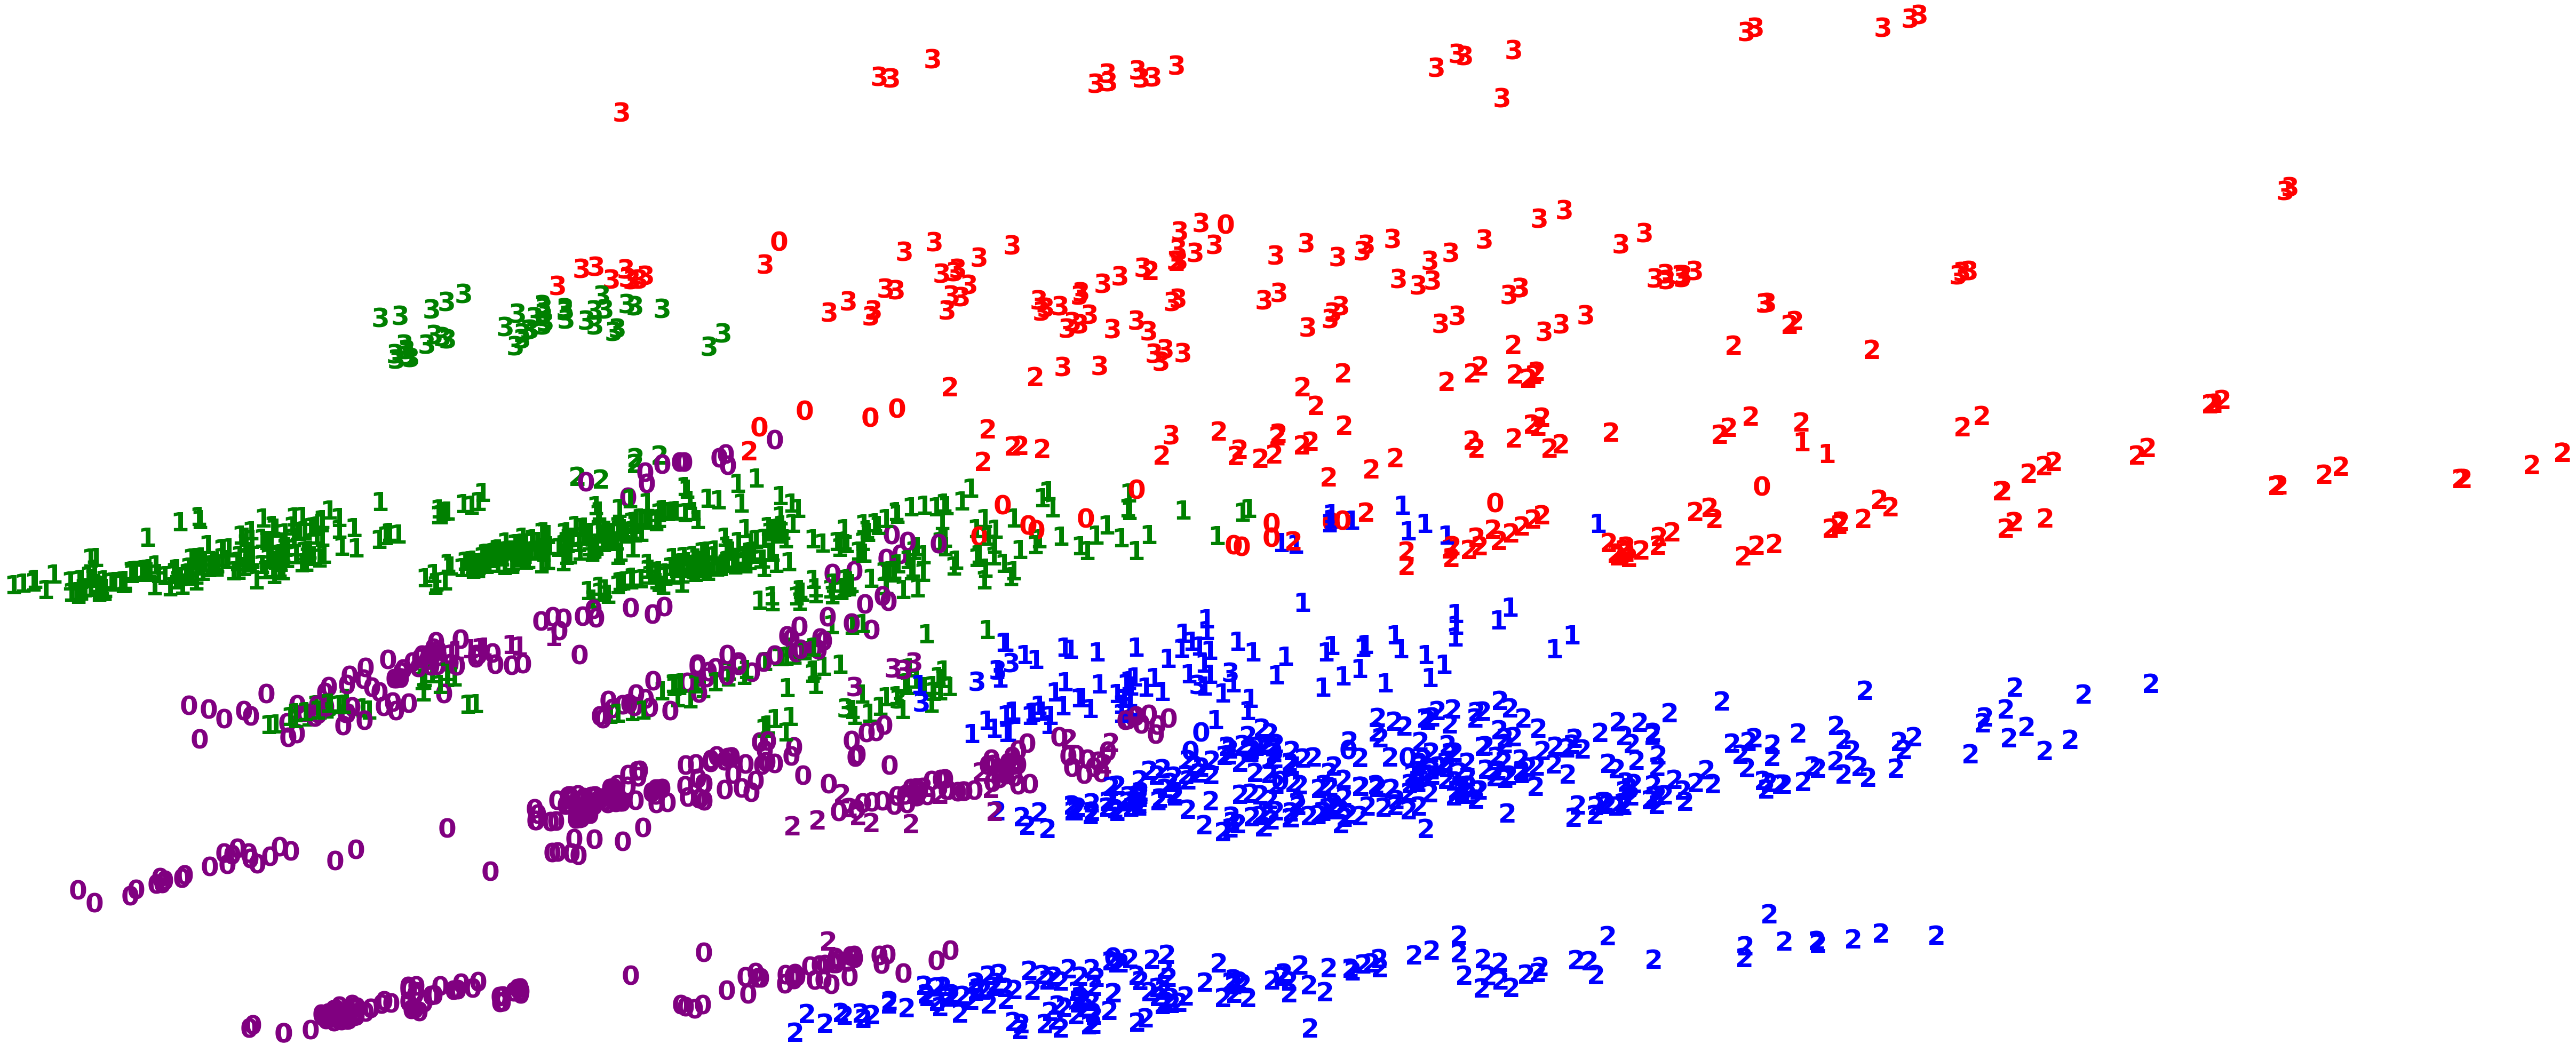

In [35]:
plt.figure(figsize=(10,5))
colors = ('r', 'g', 'b', 'purple')
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters_gau[i]),
             color=colors[y_pred[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [36]:
print("GMM ARI:        {}"
      .format(metrics.adjusted_rand_score(y_pred, clusters_gau)))
print("GMM Silhouette: {}"
      .format(metrics.silhouette_score(X_std, clusters_gau, metric='euclidean')))

GMM ARI:        0.6613649217934302
GMM Silhouette: 0.24865748616614405


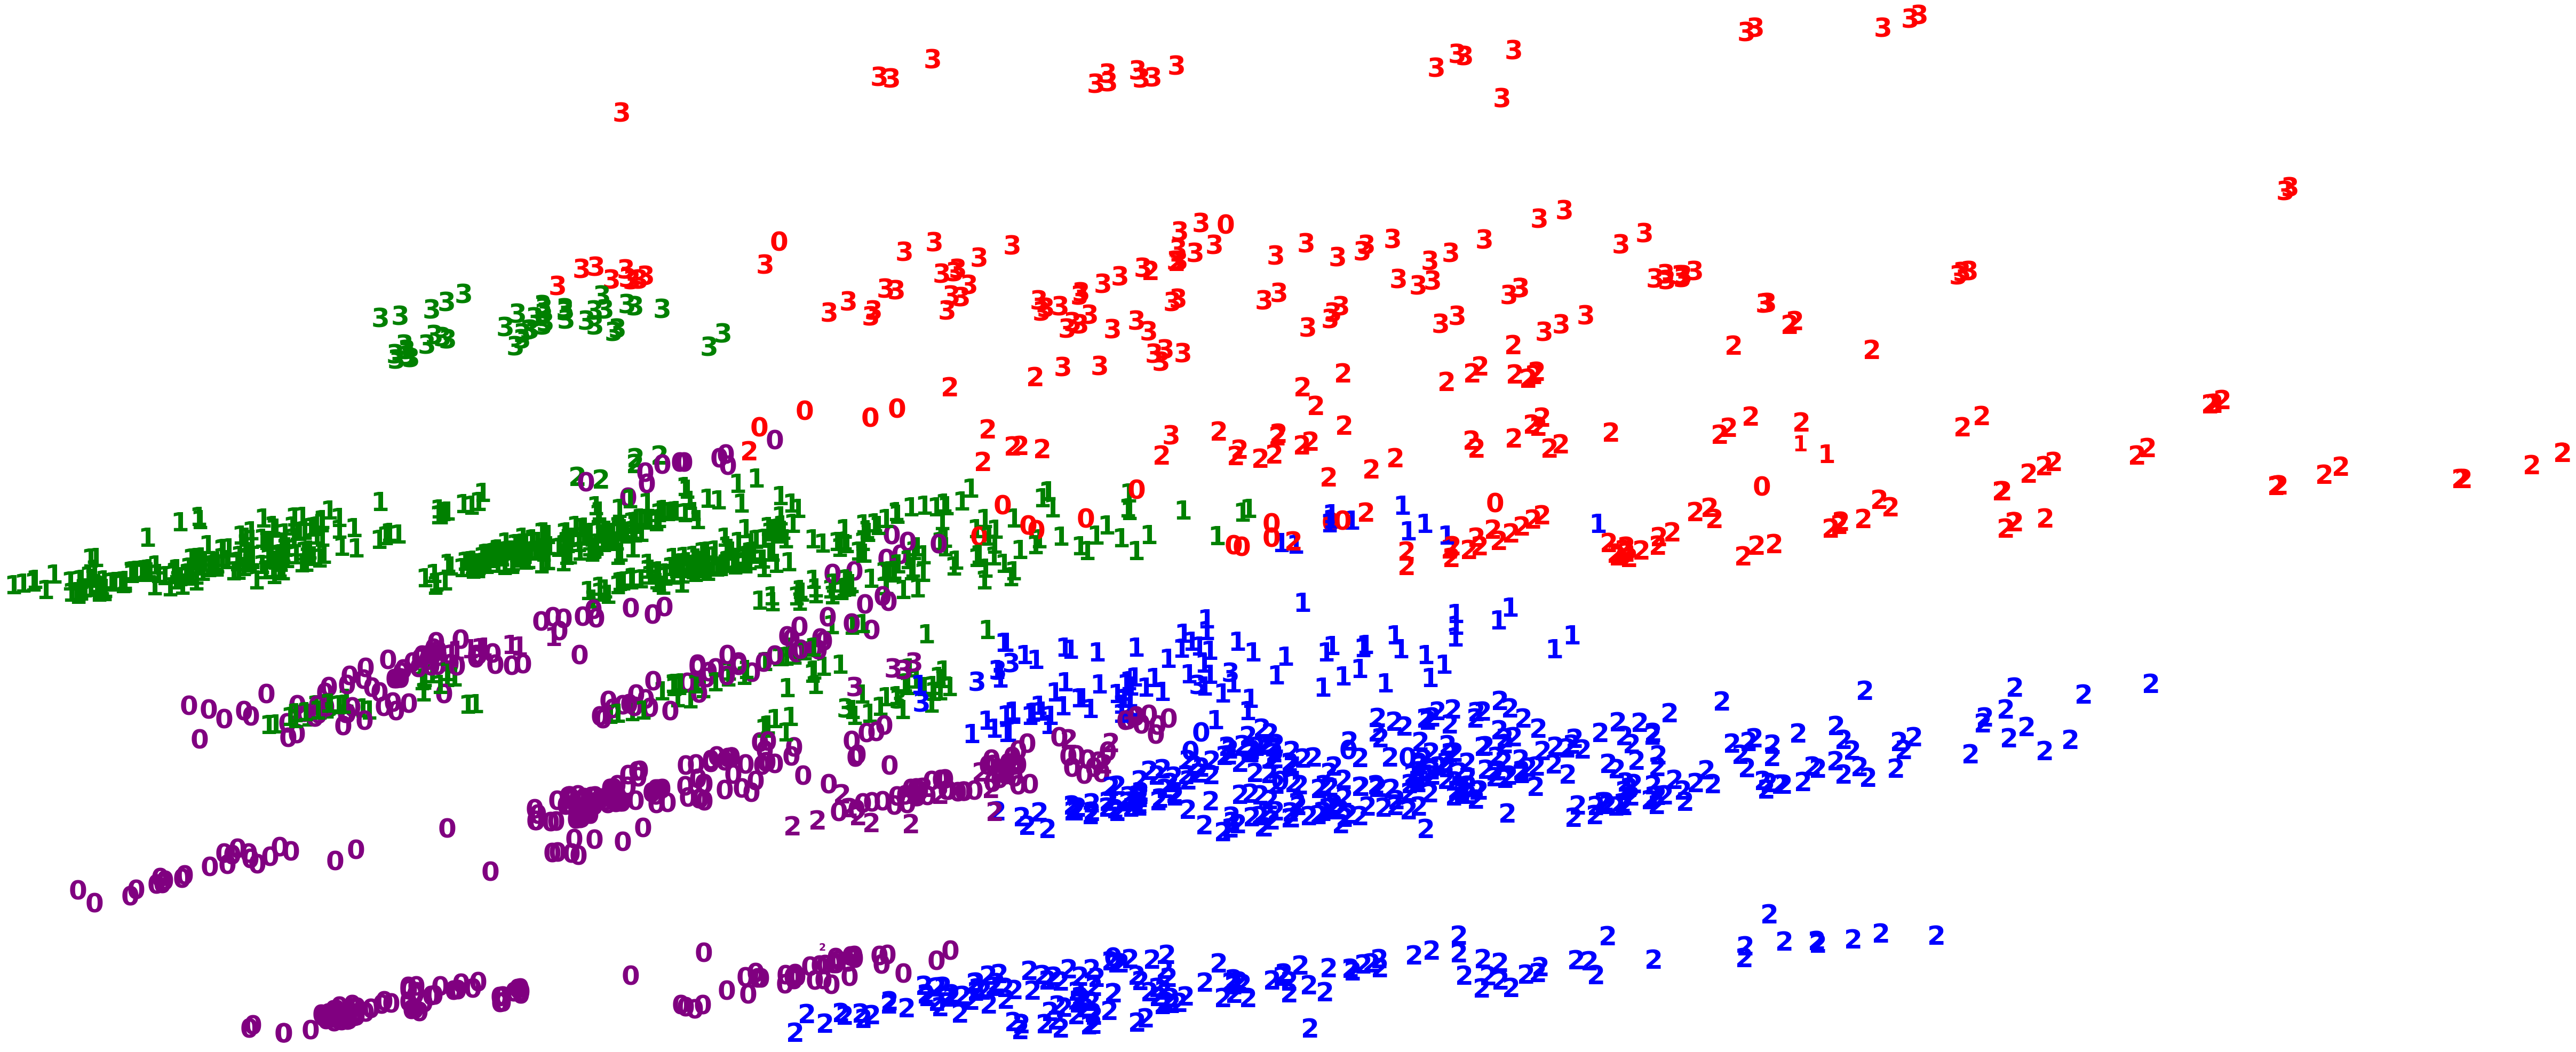

In [37]:
probs = gmm_cluster.predict_proba(X_std)
size = 50 * probs.max(1) ** 2  # Squaring emphasizes differences

plt.figure(figsize=(10,5))
colors = ('r', 'g', 'b', 'purple')
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters_gau[i]),
             color=colors[y_pred[i]],
             fontdict={'weight': 'bold', 'size': size[i]}
        )
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### ARI and Silhouette Scores for GMM with different covariance types
 - Full
 - Tied
 - Diag
 - Spherical

In [38]:
gmm_cluster_full = GaussianMixture(n_components=4, random_state=111, covariance_type="full")

clusters_full = gmm_cluster_full.fit_predict(X_std)

print("ARI score with covariance_type=full: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_full)))

print("Silhouette score with covariance_type=full: {}".format(
    metrics.silhouette_score(X_std, clusters_full, metric='euclidean')))

ARI score with covariance_type=full: 0.6613649217934302
Silhouette score with covariance_type=full: 0.24865748616614405


In [39]:
gmm_cluster_tied = GaussianMixture(n_components=4, random_state=111, covariance_type="tied")

clusters_tied = gmm_cluster_tied.fit_predict(X_std)

print("ARI score with covariance_type=tied: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_tied)))

print("Silhouette score with covariance_type=tied: {}".format(
    metrics.silhouette_score(X_std, clusters_tied, metric='euclidean')))

ARI score with covariance_type=tied: 0.6535221679011887
Silhouette score with covariance_type=tied: 0.2461748120084885


In [40]:
gmm_cluster_diag = GaussianMixture(n_components=4, random_state=111, covariance_type="diag")

clusters_diag = gmm_cluster_diag.fit_predict(X_std)

print("ARI score with covariance_type=diag: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_diag)))

print("Silhouette score with covariance_type=diag: {}".format(
    metrics.silhouette_score(X_std, clusters_diag, metric='euclidean')))

ARI score with covariance_type=diag: 0.6751618412485028
Silhouette score with covariance_type=diag: 0.26065379574908265


In [41]:
gmm_cluster_spherical = GaussianMixture(n_components=4, random_state=111, covariance_type="spherical")

clusters_spherical = gmm_cluster_spherical.fit_predict(X_std)

print("ARI score with covariance_type=spherical: {}".format(
    metrics.adjusted_rand_score(y_pred, clusters_spherical)))

print("Silhouette score with covariance_type=spherical: {}".format(
    metrics.silhouette_score(X_std, clusters_spherical, metric='euclidean')))

ARI score with covariance_type=spherical: 0.6542596123316515
Silhouette score with covariance_type=spherical: 0.2310548084341167


In [42]:
sil_full = metrics.silhouette_score(X_std, clusters_full, metric='euclidean')
sil_tied = metrics.silhouette_score(X_std, clusters_tied, metric='euclidean')
sil_diag = metrics.silhouette_score(X_std, clusters_diag, metric='euclidean')
sil_sph = metrics.silhouette_score(X_std, clusters_spherical, metric='euclidean')
ari_full = metrics.adjusted_rand_score(y_pred, clusters_full)
ari_tied =  metrics.adjusted_rand_score(y_pred, clusters_tied)
ari_diag =  metrics.adjusted_rand_score(y_pred, clusters_diag)
ari_sph =  metrics.adjusted_rand_score(y_pred, clusters_spherical)

In [43]:
print('Silhouette FULL:       ', round(sil_full, 4))
print('Silhouette TIED:       ', round(sil_tied, 4))
print('Silhouette DIAGONAL:   ', round(sil_diag, 4))
print('Silhouette SPHERICAL:  ', round(sil_sph, 4))
print('-------------------------------------------')
print('ARI FULL:      ', round(ari_full, 4))
print('ARI TIED:      ', round(ari_tied, 4))
print('ARI DIAGONAL:  ', round(ari_diag, 4))
print('ARI SPHERICAL: ', round(ari_sph, 4))

Silhouette FULL:        0.2487
Silhouette TIED:        0.2462
Silhouette DIAGONAL:    0.2607
Silhouette SPHERICAL:   0.2311
-------------------------------------------
ARI FULL:       0.6614
ARI TIED:       0.6535
ARI DIAGONAL:   0.6752
ARI SPHERICAL:  0.6543


#### PCA - Principal Components Analysis
1. First, PCA calculates the covariance matrix of the variables that you want to transform.
2. Second, it calculates the eigenvectors and the eigenvalues of the covariance matrix calculated in the previous step.
3. Third, it sorts out the eigenvectors with respect to their corresponding eigenvalues, such that the eigenvector with the highest eigenvalue comes first, the eigenvector with the second-highest eigenvalue comes next, and so on.

The first principal component is the first eigenvector after sorting, the second principal component is the second eigenvector after sorting, and so forth.

In [44]:
pca = PCA(n_components=2)

pca_components = pca.fit_transform(X_std)

pca_components = pd.DataFrame(pca_components)
pca_components['y'] = y_pred

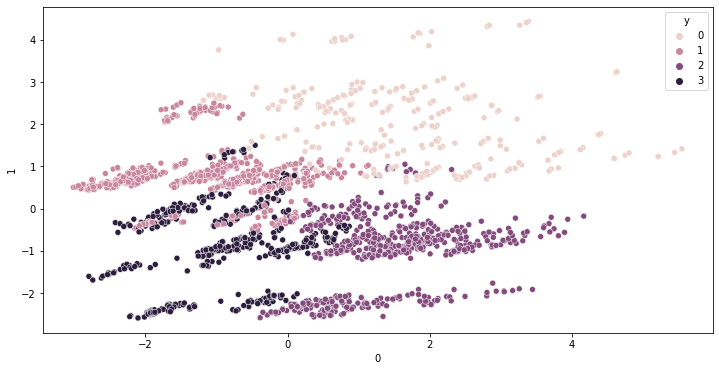

In [45]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=pca_components, x=0, y=1, hue='y');

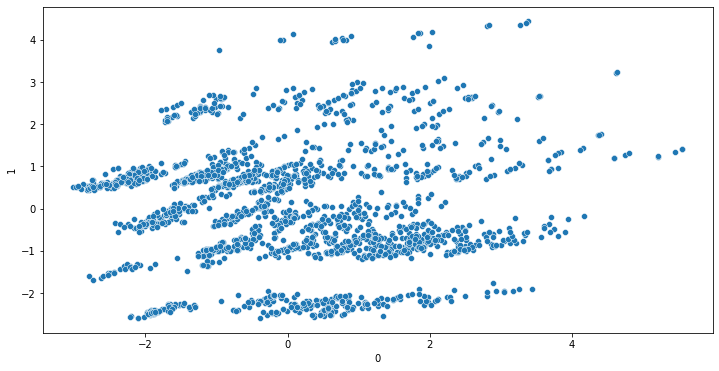

In [46]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=pca_components, x=0, y=1);

#### t-SNE - t-Distributed Stochastic Neighbor Embedding
- Minimizes the divergence between two distributions.
- Measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.
- Tries to find a good representation of high-dimensional data in low-dimensional space

In [47]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(X_std)

tsne_results = pd.DataFrame(tsne_results)
tsne_results['y'] = y_pred

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.435044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.345795
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


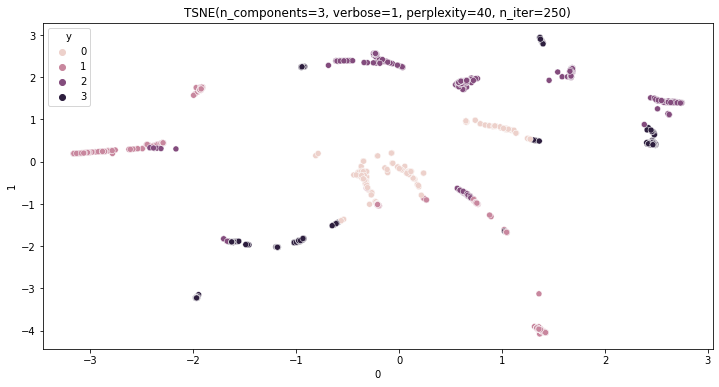

In [48]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1, hue='y')
plt.title('TSNE(n_components=3, verbose=1, perplexity=40, n_iter=250)');

In [49]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

tsne_results = pd.DataFrame(tsne_results)
tsne_results['y'] = y_pred

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.435044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.256802
[t-SNE] KL divergence after 300 iterations: 0.430928


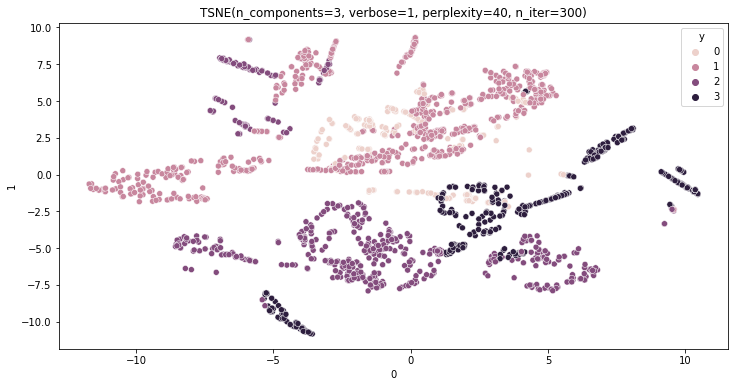

In [50]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1, hue='y')
plt.title('TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)');

In [51]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=350)
tsne_results = tsne.fit_transform(X_std)

tsne_results = pd.DataFrame(tsne_results)
tsne_results['y'] = y_pred

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.435044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.311131
[t-SNE] KL divergence after 350 iterations: 0.279593


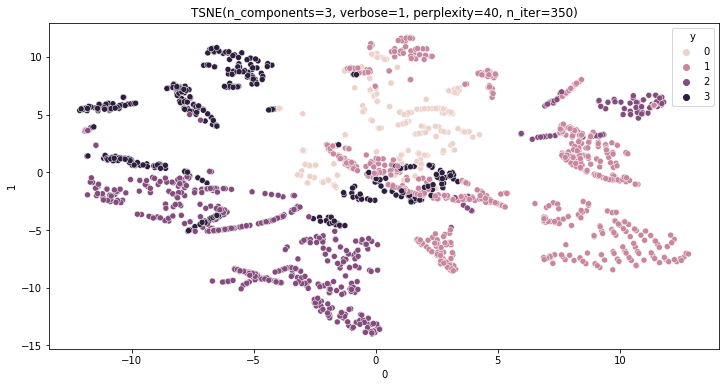

In [52]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1, hue='y')
plt.title('TSNE(n_components=3, verbose=1, perplexity=40, n_iter=350)');

In [53]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=400)
tsne_results = tsne.fit_transform(X_std)

tsne_results = pd.DataFrame(tsne_results)
tsne_results['y'] = y_pred

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.435044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.260029
[t-SNE] KL divergence after 400 iterations: 0.242344


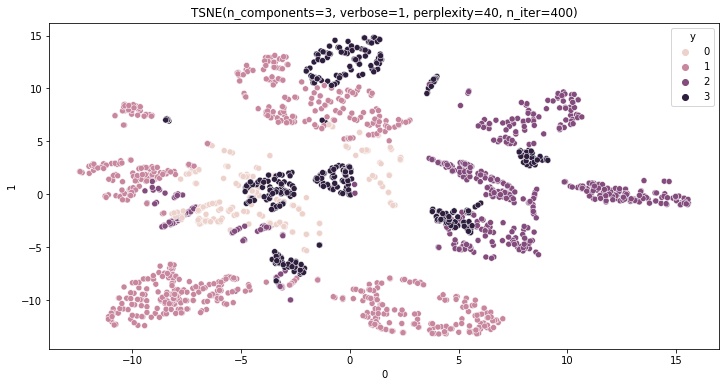

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1, hue='y')
plt.title('TSNE(n_components=3, verbose=1, perplexity=40, n_iter=400)');

In [55]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=450)
tsne_results = tsne.fit_transform(X_std)

tsne_results = pd.DataFrame(tsne_results)
tsne_results['y'] = y_pred

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.435044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.281624
[t-SNE] KL divergence after 450 iterations: 0.228242


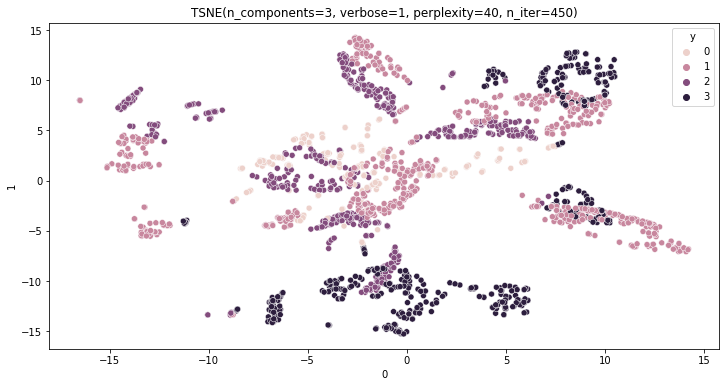

In [56]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1, hue='y')
plt.title('TSNE(n_components=3, verbose=1, perplexity=40, n_iter=450)');

In [57]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(X_std)

tsne_results = pd.DataFrame(tsne_results)
tsne_results['y'] = y_pred

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.435044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.380733
[t-SNE] KL divergence after 500 iterations: 0.224596


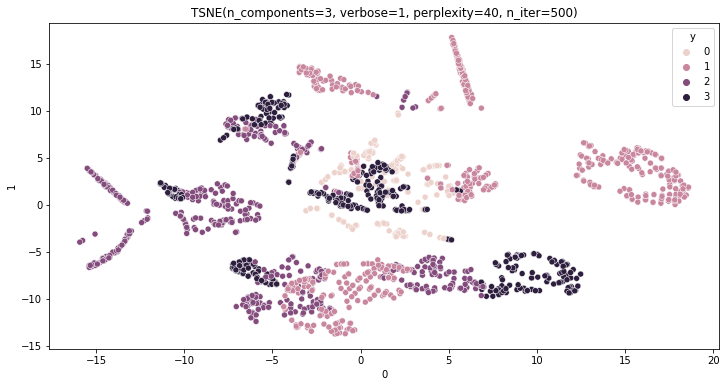

In [58]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1, hue='y')
plt.title('TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)');

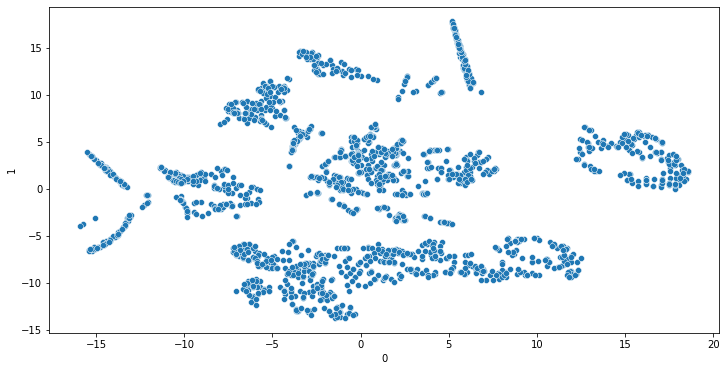

In [59]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=tsne_results, x=0, y=1);

#### UMAP - Uniform Manifold Approximation and Projection
- Fast and can handle large datasets.
- Supports a wide variety of distance metrics, including cosine and correlation distances.

In [60]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

umap_results = pd.DataFrame(umap_results)
umap_results['y'] = y_pred

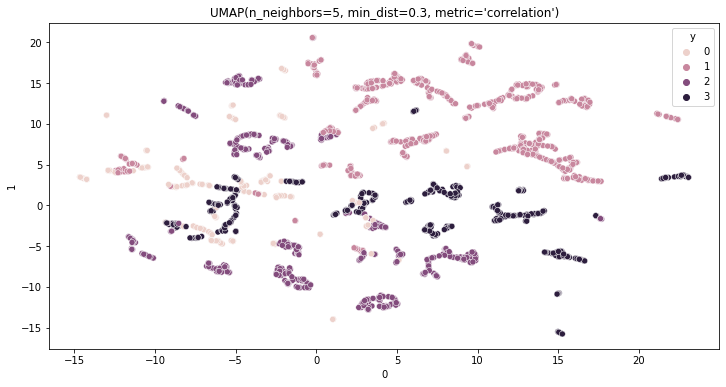

In [61]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=umap_results, x=0, y=1, hue='y')
plt.title("UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')");

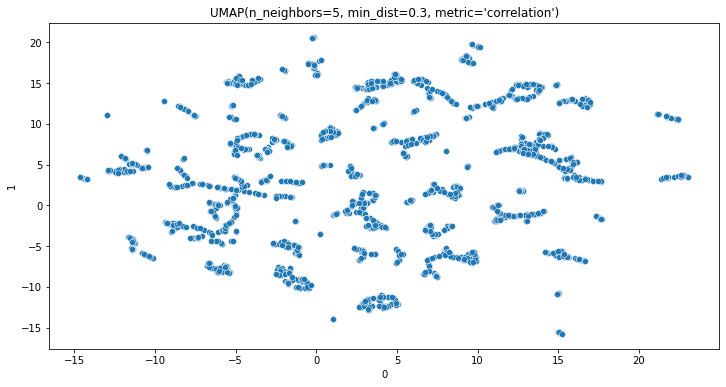

In [62]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=umap_results, x=0, y=1)
plt.title("UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')");

In [63]:
umap_results = umap.UMAP(n_neighbors=9,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X_std)

umap_results = pd.DataFrame(umap_results)
umap_results['y'] = y_pred

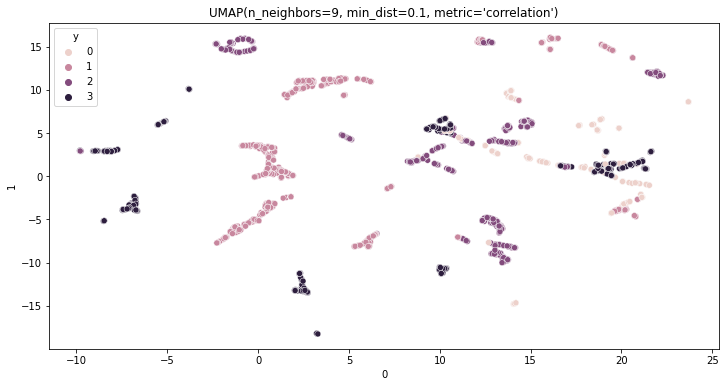

In [64]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=umap_results, x=0, y=1, hue='y')
plt.title("UMAP(n_neighbors=9, min_dist=0.1, metric='correlation')");

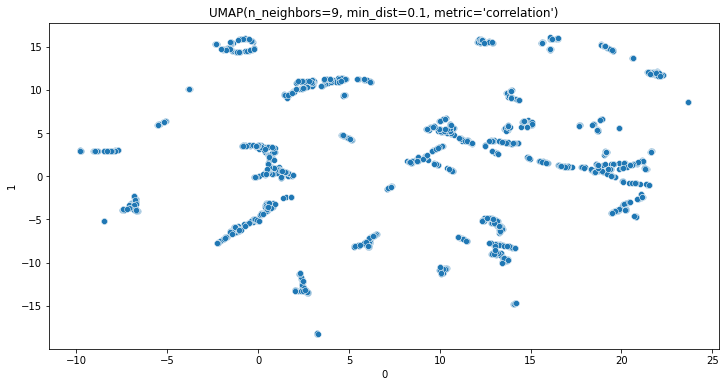

In [65]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=umap_results, x=0, y=1)
plt.title("UMAP(n_neighbors=9, min_dist=0.1, metric='correlation')");

In [66]:
umap_results = umap.UMAP(n_neighbors=9,
                      min_dist=0.1,
                      metric='cosine').fit_transform(X_std)

umap_results = pd.DataFrame(umap_results)
umap_results['y'] = y_pred

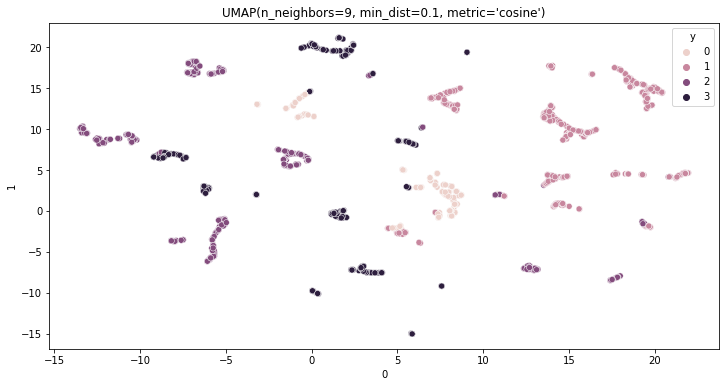

In [67]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=umap_results, x=0, y=1, hue='y')
plt.title("UMAP(n_neighbors=9, min_dist=0.1, metric='cosine')");

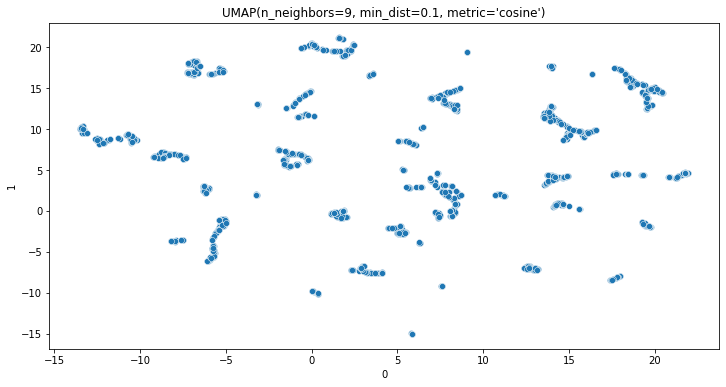

In [68]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=umap_results, x=0, y=1)
plt.title("UMAP(n_neighbors=9, min_dist=0.1, metric='cosine')");

### Answers

- Your end user and the value that your project provides to them
 - Any company looking for customer segmentation statistics
 - It provides 
 
 
- Quantifiable results based on the research that you've conducted
 - API and Silhouette scores for all tests done
 
 
- The visuals that you chose and what they represent for your research
 - Continuous and discrete variable graphs
 - Cluster and scatter plots for each respective method


- A specified research question that your model addresses
 - Can you identify target customers based on known r unknown characteristics?


- How you chose your model specification and what alternatives you compared it to
 - Elbow method to determine best K value
 - API and Silhouette values to show best model


- The practical uses of your model for an audience of interest
 - Identifying customer tendencies and previously unidentified needs
 - Understanding the target customers for preper marketing and development


- Any weak points or shortcomings of your model
 - Better data needed for 'Settlement size'
 - 'Occupation' and 'Income' is not as correlated as it seems like it should be

- 2 Cluster KMeans Silhouette Score: 0.24977843688092582
- 3 Cluster KMeans Silhouette Score: 0.2711846855734802
- 4 Cluster KMeans Silhouette Score: 0.26879180394522123


- 2 Cluster KMeans ARI Score: 0.4082900175836153
- 3 Cluster KMeans ARI Score: 0.5773015850647832
- 4 Cluster KMeans ARI Score: 1.0


- 2 Cluster MiniBatch KMeans Silhouette Score: 0.25243496195267057
- 3 Cluster MiniBatch KMeans Silhouette Score: 0.23861958936111638
- 4 Cluster MiniBatch KMeans Silhouette Score: 0.21618424695007804


- 2 Cluster MiniBatch KMeans ARI Score: 0.4201016483816582
- 3 Cluster MiniBatch KMeans ARI Score: 0.5031745340342478
- 4 Cluster MiniBatch KMeans ARI Score: 0.32098898719604774


- Silhouette WARD:      0.231
- Silhouette COMPLETE:  0.2325
- Silhouette AVERAGE:   0.2202


- ARI WARD:      0.3386
- ARI COMPLETE:  0.2679
- ARI AVERAGE:   0.426


- Silhouette FULL:        0.2487
- Silhouette TIED:        0.2462
- Silhouette DIAGONAL:    0.2607
- Silhouette SPHERICAL:   0.2311


- ARI FULL:       0.6614
- ARI TIED:       0.6535
- ARI DIAGONAL:   0.6752
- ARI SPHERICAL:  0.6543

#### Top Silhouette Score
1. KMeans (3 Cluster)
2. KMeans (4 Cluster)

#### Top ARI Score
1. KMeans (4 Cluster)
2. Gaussian (Diagonal)

### Next Steps
 - Continuously update and add new data to the data set
 - Group feature variables together to create more relationships between them
 - Explore each cluster in a separate analysis
